# Kriging Example1

- Author: Mohit S. Chauhan 
- Date: Jan 08, 2019

In this example, Kriging is used to generate a surrogate model for a given data. In this data, sample points are generated using STS class and functional value at sample points are estimated using a model defined in python script ('python_model_function.py).

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the STS, RunModel and Krig class from UQpy.

In [1]:
from UQpy.Surrogates import Kriging
from UQpy.SampleMethods import RectangularStrata, RectangularSTS
from UQpy.RunModel import RunModel
from UQpy.Distributions import Gamma
import numpy as np
import matplotlib.pyplot as plt

Create a distribution object.

In [2]:
marginals = [Gamma(a= 2., loc=1., scale=3.)]

Create a strata object.

In [3]:
strata = RectangularStrata(nstrata=[20])

Run stratified sampling

In [4]:
x = RectangularSTS(dist_object=marginals, strata_object=strata, nsamples_per_stratum=1, random_state=2)

RunModel is used to evaluate function values at sample points. Model is defined as a function in python file 'python_model_function.py'.

In [5]:
rmodel = RunModel(model_script='python_model_1Dfunction.py', delete_files=True)
rmodel.run(samples=x.samples)

In [6]:
K = Kriging(reg_model='Linear', corr_model='Gaussian', nopt=20, corr_model_params=[1], random_state=2)
K.fit(samples=x.samples, values=rmodel.qoi_list)
print(K.corr_model_params)

[1.84408102]


/Users/dimitris/PythonProjects/UQpy/src/UQpy/Surrogates/Kriging.py:207: RuntimeWarning: invalid value encountered in log
  ll = ll + (np.log(np.linalg.det(sigma_[out_dim] * r__)) + m * (np.log(2 * np.pi) + 1))/2


Kriging surrogate is used to compute the response surface and its gradient.

In [7]:
num = 1000
x1 = np.linspace(min(x.samples), max(x.samples), num)

y, y_sd = K.predict(x1.reshape([num, 1]), return_std=True)
y_grad = K.jacobian(x1.reshape([num, 1]))

Actual model is evaluated at all points to compare it with kriging surrogate.

In [8]:
rmodel.run(samples=x1, append_samples=False)

This plot shows the input data as blue dot, blue curve is actual function and orange curve represents response curve. This plot also shows the gradient and 95% confidence interval of the kriging surrogate.

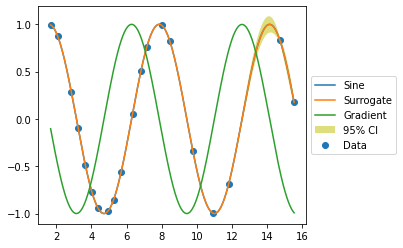

In [9]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(x1, rmodel.qoi_list, label='Sine')
plt.plot(x1, y, label='Surrogate')
plt.plot(x1, y_grad, label='Gradient')
plt.scatter(K.samples, K.values, label='Data')
plt.fill(np.concatenate([x1, x1[::-1]]), np.concatenate([y - 1.9600 * y_sd,
                        (y + 1.9600 * y_sd)[::-1]]),
         alpha=.5, fc='y', ec='None', label='95% CI')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()